# Transfer Learning

Este tutorial fue elaborado a partir de las siguientes fuentes...

* [Deep Learning For Beginners Using Transfer Learning In Keras](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e).
* [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a).
* [Transfer Learning Introduction](https://www.hackerearth.com/practice/machine-learning/transfer-learning/transfer-learning-intro/tutorial/).
* [Keras: Feature extraction on large datasets with Deep Learning](https://www.pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/).
* [Transfer learning from pre-trained models](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751).

## ¿Qué es *Transfer Learning*?

Si bien el entrenamiento de una **CNN** desde cero es posible para proyectos con datasets pequeños, la mayoría de las aplicaciones requieren enormes cantidades de datos procesados ​​y mucha potencia computacional. Ahí es donde entra en juego *transfer learning* (**TL**) o *aprendizaje de transferencia*. Su definición es la siguiente:

> **Situación en la que se aprovecha lo aprendido en un entorno para mejorar la generalización en otro entorno**.

En el contexto de *deep learnig*, **TL** implica tomar un modelo ya entrenado para un problema específico, y usar sus parámetros como parte del aprendizaje de un nuevo modelo en otro problema diferente.

De esta manera, **TL** tiene las siguiente ventajas...

1. Se puede entrenar con **datasets mucho más pequeños**.
2. Requiere **mucha menos potencia computacional**, ya que usamos parámetros pre-entrenados.

## ¿Por qué **TL** funciona bien?

Como vimos en los laboratorios anteriores, el objetivo de entrenar una **CNN** es encontrar los valores óptimos en cada una de las matrices de filtro que se han definido en la arquitectura de la red (es decir, los parámetros del modelo). Cuando observamos qué han aprendido a reconocer los filtros en cada capa de la **CNN**, o por qué se activa cada filtro, podemos ver cosas realmente interesantes.

![](https://miro.medium.com/max/2177/1*jPCEik198_CjtmSL2H6o4g.png)

Los filtros en las primeras capas de la **CNN** aprenden a reconocer **colores** y ciertas **líneas horizontales y verticales**. Las siguientes capas aprenden a reconocer **formas sencillas** usando las líneas y los colores aprendidos en las capas anteriores.

![](https://miro.medium.com/max/1963/1*1Y6HZxK-lOmqB8KnizTCow.png)

Luego, las siguientes capas aprenden a reconocer **texturas**, luego **partes de objetos** como piernas, ojos, nariz, etcétera. Finalmente, los filtros en las últimas capas se activan por **objetos completos** como perros, automóviles, etcétera.

Cuando los investigadores comenzaron a observar que es lo que las **CNN** aprendían, notaron que redes entrenadas con datasets de imágenes diferentes exhibían un fenómeno curioso en común: las características de las primeras capas **no parecen ser específicas de un dataset en particular, sino que son genéricas**, y por lo tanto son aplicables a muchos problemas.

Y es éste fenómeno el que se aprovecha para hacer **TL** cuando usamos **CNN** para procesamiento de imágenes. Básicamente, primero se entrena una *red base* sobre un *dataset base*, y luego se reutilizan las características aprendidas en una segunda *red específica* para que se entrene con un nuevo *dataset específico*. Este proceso tenderá a funcionar si las características son generales, es decir, adecuadas para el problema original y el problema nuevo.

# *Transfer Learning* con una **CNN** pre-entrenada

Tutorial extraído de https://www.tensorflow.org/tutorials/images/transfer_learning.

En este tutorial vamos a clasificar imágenes de *Gatos vs. Perros* utilizando **TL** de una red pre-entrenada. Como ya vimos antes, la intuición detrás de **TL** es que si un modelo es entrenado con un dataset lo suficientemente grande y general, el modelo servirá efectivamente como un modelo genérico del *mundo visual*. Luego, se pueden aprovechar los *feature maps* aprendidos sin tener que comenzar desde cero a entrenar un nuevo modelo.

En este laboratorio, vamos a ver dos formas de hacer **TL** con un modelo previamente entrenado:

1. **Extracción de Características**: Utiliza los filtros aprendidos por una red para extraer características significativas de nuevas imágenes. Simplemente se agrega un nuevo clasificador que se entrenará desde cero, encima del modelo previamente entrenado para que pueda reutilizar los *feature maps* aprendidos previamente para un nuevo dataset.

    No es necesario (re) entrenar todo el modelo. La **CNN** base ya contiene características que son genéricamente útiles para clasificar imágenes. Sin embargo, la parte final de la clasificación del modelo preentrenado es específica de la tarea de clasificación original y, posteriormente, específica del conjunto de clases en las que se entrenó el modelo.

![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-9-15-21-pm.png?w=1496)

2. **Ajuste Fino**: *Descongela* algunas de las capas superiores de una **CNN** base y entrena conjuntamente las capas del clasificador recién agregadas y las últimas capas de la **CNN** base. Esto permite *ajustar* las representaciones de características de orden superior en el modelo base para hacerlas más relevantes para la tarea específica.

El flujo de trabajo general que vamos a seguir es el siguiente:

1. Examinar y comprender los datos.
2. Crear una *tubería de entrada*, en este caso utilizando el objeto `ImageDataGenerator` de la librería *Keras*.
3. Compilar el nuevo modelo. Cargar modelo base previamente entrenado y agregar nuevas capas de clasificación en la parte superior.
4. Entrenar el nuevo modelo.
5. Evaluar el modelo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

## Preprocesamiento de los datos

### Descargar los datos

Vamos a utilizar [TensorFlow Datasets](http://tensorflow.org/datasets) para cargar el dataset de *Gatos y Perros*.

El paquete `tfds` es la forma más fácil de cargar datos predefinidos. Si tienes tus propios datos y estás interesado en importarlos con *TensorFlow*, se pude consultar el tutorial [load images](https://www.tensorflow.org/tutorials/load_data/images).

In [3]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

El método `tfds.load` descarga y almacena los datos en caché, y devuelve un objeto` tf.data.Dataset`. Estos objetos proporcionan métodos potentes y eficientes para manipular datos y canalizarlos a un modelo.

Primero tenemos que dividir el dataset `cats_vs_dogs` en 3 conjuntos: entrenamiento, validación, y prueba. Para esto usamos la función de subdivisión para dividir el dataset: *80%*, *10%*, *10%* de los datos en cada conjunto respectivamente.

In [4]:
# Split the dataset into train, validation, and test.
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
                                                            split=list(splits),
                                                            with_info=True,
                                                            as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8LCZP8/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Los objetos resultantes `tf.data.Dataset` contienen pares `(imagen, etiqueta) `. Donde las imágenes tienen *forma variable* y **3** canales, y la etiqueta es un escalar.

In [5]:
num_classes = metadata.features['label'].num_classes

print(f'Number of Classes: {num_classes}')

Number of Classes: 2


Mostramos las *3* primeras imágenes y etiquetas del conjunto de entrenamiento...

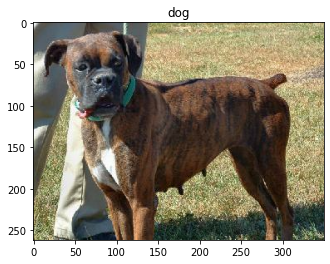

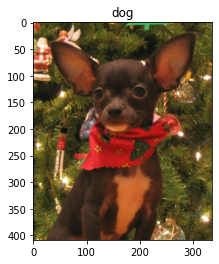

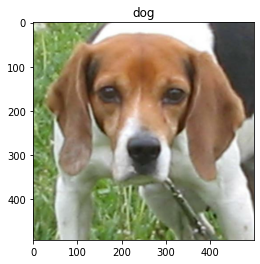

In [6]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### Formatear los datos

Usamos el módulo `tf.image` para formatear las imágenes para nuestro problema. Primero cambiamos el tamaño de las imágenes a un tamaño de entrada fijo, y luego cambiamos la escala de los canales de entrada a un rango entre `[-1, 1]`.

In [7]:
IMG_SIZE = 160 # All images will be resized to 160 x 160.

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Aplicamos el formateo a cada imagen en el dataset utilizando el método de `map` de la clase `tf.data.Dataset`.

In [8]:
# Train.
train = raw_train.map(format_example)
# Validation.
validation = raw_validation.map(format_example)
# Test.
test = raw_test.map(format_example)

Ahora mezclamos y procesamos los datos por lotes.

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
# Train.
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# Validation.
validation_batches = validation.batch(BATCH_SIZE)
# Test.
test_batches = test.batch(BATCH_SIZE)

Adelantándonos, guardamos el conjunto de datos ya procesado para una futura experimentación.

In [11]:
# Para el modelo con clasificador SVM...
Cat_vs_Dog = {'TRAIN': train_batches,
              'VALIDATION': validation_batches,
              'TEST': test_batches}

Inspeccionamos un lote de datos.

In [12]:
for image_batch, label_batch in train_batches.take(1):
  pass

print(f'Dimensiones Lote de Imágenes: {image_batch.shape}')
print(f'Dimensiones Lote de Etiquetas: {label_batch.shape}')

Dimensiones Lote de Imágenes: (32, 160, 160, 3)
Dimensiones Lote de Etiquetas: (32,)


## Crear el modelo base a partir de una **CNN** previamente entrenada

Ahora vamos a crear nuestro modelo base a partir de la *CNN* **MobileNet V2**, desarrollada en **Google**.

![](https://machinethink.net/images/mobilenet-v2/Classifier@2x.png)

Esta **CNN** está pre-entrenada con el dataset [ImageNet](https://image-net.org), un dataset con 1.4 millones de imágenes distribuidas en 1000 clases. *ImageNet* tiene un conjunto de datos para investigación bastante variado, con categorías como `jackfruit` o `syringe`. Sin embargo, esta *base de conocimiento* nos ayudará a distinguir a los gatos y perros en nuestro dataset específico.

Primero, debemos elegir qué capa de *MobileNet V2* se usará para la extracción de características. Obviamente, la última capa de clasificación no es muy útil. En su lugar, vamos a a tomar la última capa antes de la operación de aplanar (`flatten`). Esta capa se llama *bottleneck layer* (cuello de botella). Las características de la capa *bottleneck* conservan mucha generalidad en comparación con la capa final.

Para esto vamos a crear una instancia del modelo *MobileNet V2* con parámetros ya entrenados sobre el dataset *ImageNet*. Al especificar el argumento `include_top = False`, carga la red sin incluir las capas de clasificación, lo que es ideal para la extracción de características.

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2.
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


Este extractor de características convierte cada imagen de `160 x 160 x 3` en un bloque de features de `5 x 5 x 1280`. Podemos ver esto reflejado en la forma del lote de imágenes de ejemplo.

In [14]:
feature_batch = base_model(image_batch)

print(f'Dimensiones Lote de Features: {feature_batch.shape}')

Dimensiones Lote de Features: (32, 5, 5, 1280)


## Extracción de características

Ahora vamos a *congelar* la *base convolucional* creada a partir de la etapa anterior, y vamos a usar eso como un extractor de características.
Luego se añadirá un clasificador en la parte superior de la misma y se entrenará al nuevo clasificador.

### Congelar la base convolucional

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Al congelar evitamos que los parámetros en una capa determinada se actualicen durante el entrenamiento. *MobileNet V2* tiene muchas capas, por lo que vamos a establecer el argumento `layer.trainable = False` para congelar todas las capas.

In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture.
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Agregar un nuevo clasificador

Para generar predicciones a partir del bloque de características vamos a diseñar una nueva **ANN**.

La primera capa de la **ANN** toma el promedio para cada *feature map* de `5 x 5` que entrega la última capa de *MobileNet V2*. Para esto agregamos al modelo una capa `keras.layers.GlobalAveragePooling2D`, que convierte los *features maps* en un solo vector de 1280 elementos por imagen.

In [17]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(f'Dimensiones Lote de Features Promediado: {feature_batch_average.shape}')

Dimensiones Lote de Features Promediado: (32, 1280)


Agregamos una capa `keras.layers.Dense` para convertir estas características en una sola predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un `logit`, los números positivos predicen la clase **1**, y los números negativos predicen la clase **0**.

In [18]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

print(f'Dimensiones Lote de Predicciones: {prediction_batch.shape}')

Dimensiones Lote de Predicciones: (32, 1)


Ahora apilaremos el extractor de características y ambas capas definidas usando un modelo `keras.Sequential`.

In [19]:
model = keras.Sequential([base_model,
                          global_average_layer,
                          prediction_layer])

### Compilar el modelo

Debemos compilar el modelo antes de entrenarlo. Como hay dos clases, usaremos una función de pérdida binaria.

In [20]:
base_learning_rate = 0.0001

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Los **2.5M** de parámetros en *MobileNet V2* están congelados, pero hay **1.2K** *parámetros entrenables* en la capa densa.

### Entrenar el modelo

Después de entrenar durante 10 *epochs*, deberíamos obtener una precisión cercana al *96%*.

In [22]:
# Validación sin Entrenamiento.
validation_steps = 20

loss, accuracy = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 4s 79ms/step - loss: 5.0677 - accuracy: 0.5719


In [23]:
initial_epochs = 10

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 76s 121ms/step - loss: 0.9418 - accuracy: 0.8772 - val_loss: 0.4003 - val_accuracy: 0.9475
Epoch 2/10
582/582 [==============================] - 68s 113ms/step - loss: 0.3180 - accuracy: 0.9588 - val_loss: 0.2200 - val_accuracy: 0.9652
Epoch 3/10
582/582 [==============================] - 70s 116ms/step - loss: 0.2446 - accuracy: 0.9688 - val_loss: 0.1875 - val_accuracy: 0.9686
Epoch 4/10
582/582 [==============================] - 71s 119ms/step - loss: 0.2202 - accuracy: 0.9733 - val_loss: 0.1538 - val_accuracy: 0.9746
Epoch 5/10
582/582 [==============================] - 72s 119ms/step - loss: 0.1951 - accuracy: 0.9766 - val_loss: 0.1419 - val_accuracy: 0.9772
Epoch 6/10
582/582 [==============================] - 73s 122ms/step - loss: 0.1783 - accuracy: 0.9795 - val_loss: 0.1222 - val_accuracy: 0.9785
Epoch 7/10
582/582 [==============================] - 68s 113ms/step - loss: 0.1711 - accuracy: 0.9810 - val_loss: 0.1255 - val_ac

### Curvas de aprendizaje

Veamos las curvas de aprendizaje para *accuracy* / *loss* sobre los conjuntos de entrenamiento y validación cuando se usa el modelo base *MobileNet V2* como un extractor de características fijas.

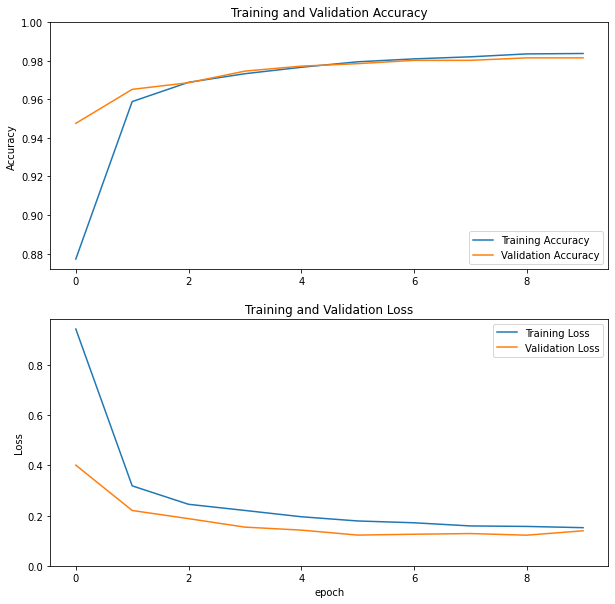

In [24]:
plt.figure(figsize=(10, 10))

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

In [25]:
loss, accuracy = model.evaluate(test_batches)

print(f'Accuracy: {accuracy}')
print(f'Loss: {loss}')

73/73 [==============================] - 6s 86ms/step - loss: 0.1970 - accuracy: 0.9785
Accuracy: 0.9785038828849792
Loss: 0.19696474075317383


**Observación**

Finalizamos la experimentación con un *accuracy* próximo al **0.98**.
Un resultado excelente para tener en cuenta que solo fue necesario diseñar, compilar, y entrenar una única capa de clasificación.

## Resumen:

**Uso de un modelo previamente entrenado para la extracción de características**: Cuando se trabaja con un dataset pequeño, es común aprovechar las características aprendidas por un modelo entrenado en un dataset más grande en el mismo dominio del problema. Esto se hace creando instancias del modelo pre-entrenado y agregando un clasificador completamente conectado en la parte superior (al final). El modelo pre-entrenado está *congelado* y solo los pesos del clasificador se actualizan durante el entrenamiento.
En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y solo entrenó a un clasificador que determina la clase de imagen dado ese conjunto de características extraídas.

---

## **Ejercicio 3.1** (OPCIONAL)

Utilizar *MobileNet V2* y los conceptos de *Transfer Learning* revisados en el tutorial anterior para entrenar un clasificador binario para el dataset que puede descargar en este [link](https://drive.google.com/file/d/11CTzx2PVxMhU4mvBWOZcJAx1nRM03l86/view?usp=sharing).

**NOTA**: Recuerden que deben reemplazar la cadena `/content/drive/My Drive/PATH_TO_DATASET` por el path al directorio del dataset.

**Preparando el entorno**

In [26]:
from google.colab import drive

# Montamos la unida de Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!cp -r drive/MyDrive/Diplomatura/DataSet/ DataSet

In [28]:
# Importamos librerías de Python
import pathlib

In [29]:
# FUNCIONES AUXILIARES

# Obtiene la etiqueta de una imagen a partir del directorio que la contiene.
def get_label(file_path):
  # Converts the path to a list of path components.
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory.
  class_name = parts[-2]
  # FIX: Necesitamos un ÚNICO valor. Solo nos interesa el índice de la etiqueta.
  return tf.argmax(class_name == CLASS_NAMES)

# Procesa una imagen para adecuarla a la estructura de datos de entrada de la CNN.
def decode_img(img):
  # Converts the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0, 1] range.
  # Multiplies by 2 and subtracts 1 to stay in the [-1, 1] range.
  img = (tf.image.convert_image_dtype(img, tf.float32) * 2) - 1
  # Resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

# Devuelve una imagen y su etiqueta a partir del directorio que recibe como argumento.
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string.
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

**Preprocesamiento del conjunto de datos**

In [30]:
# Dirección al directorio que contiene el dataset de imágenes.
data_Path = pathlib.Path('DataSet/')

image_count = len(list(data_Path.glob('*/*.jpg')))
print(f'Cantidad de imágenes: {image_count}')

Cantidad de imágenes: 121


In [31]:
CLASS_NAMES = [item.name for item in data_Path.glob('*')]
print(f'Clases: {CLASS_NAMES}')

Clases: ['sunflower', 'camera']


In [32]:
# Divide al dataset en 3 conjuntos: Train, Val, Test.
train_size = int(0.6 * image_count)
val_size = int(0.2 * image_count)
test_size = int(0.2 * image_count)

print(f'Cantidad Imágenes para Entrenamiento: {train_size}')
print(f'Cantidad Imágenes para Validación: {val_size}')
print(f'Cantidad Imágenes para Evaluación: {test_size}')

Cantidad Imágenes para Entrenamiento: 72
Cantidad Imágenes para Validación: 24
Cantidad Imágenes para Evaluación: 24


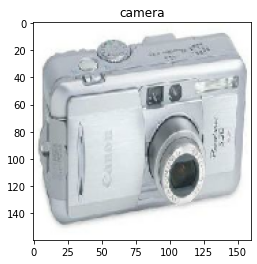

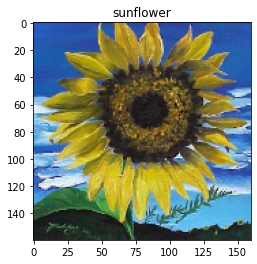

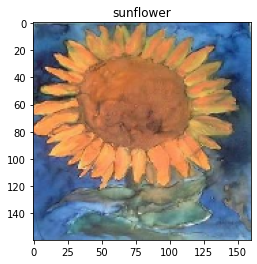

In [33]:
# Carga la lista de imágenes.
list_DS = tf.data.Dataset.list_files(str(data_Path/'*/*'))

# Carga las imagenes del dataset junto a sus etiquetas, y las desordena.
labeled_DS = list_DS.map(process_path)
labeled_DS.shuffle(1000)

# Muestra tres imágenes tomadas aleatoriamente del dataset.
for image, label in labeled_DS.take(3):
  plt.figure()
  plt.imshow(image / 2 + 0.5) # Go back to [0, 1] range to avoid warnings!
  plt.title(CLASS_NAMES[label])

In [34]:
train = labeled_DS.take(train_size)
val = labeled_DS.skip(train_size).take(val_size)
test = labeled_DS.skip(train_size).skip(val_size).take(test_size)

# Crea los BATCHES para cada conjunto.
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Adelantándonos, guardamos el conjunto de datos ya procesado para una futura experimentación.

In [35]:
# Para el modelo con clasificador SVM...
Camera_vs_Sunflower = {'TRAIN': train_batches,
                       'VALIDATION': validation_batches,
                       'TEST': test_batches}

**Definición del modelo**

In [36]:
# Create the base model from the pre-trained model MobileNet V2.
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

# Congela el modelo base (feature extraction).
base_model.trainable = False

# Let's take a look at the base model architecture.
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [37]:
# Crea la 1er capa de la ANN que vamos a usar como clasificador.
global_average_layer = keras.layers.GlobalAveragePooling2D()
# Crea la 2da capa de la ANN que vamos a usar como clasificador.
prediction_layer = keras.layers.Dense(1)

# Apila el extractor de características y las dos capas de la ANN.
model = keras.Sequential([base_model,
                          global_average_layer,
                          prediction_layer])

# Compila el modelo antes de entrenarlo. Utilizamos una función de pérdida binaria.
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Let's take a look at the complete model architecture.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [38]:
initial_epochs = 10

history = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Epoch 1/10
3/3 [==============================] - 5s 968ms/step - loss: 2.0425 - accuracy: 0.7222 - val_loss: 0.2850 - val_accuracy: 0.8333
Epoch 2/10
3/3 [==============================] - 0s 158ms/step - loss: 1.7767 - accuracy: 0.7222 - val_loss: 3.4157 - val_accuracy: 0.6250
Epoch 3/10
3/3 [==============================] - 0s 150ms/step - loss: 2.4552 - accuracy: 0.6667 - val_loss: 2.2829 - val_accuracy: 0.6667
Epoch 4/10
3/3 [==============================] - 0s 152ms/step - loss: 2.5590 - accuracy: 0.7639 - val_loss: 2.7106 - val_accuracy: 0.7917
Epoch 5/10
3/3 [==============================] - 0s 157ms/step - loss: 2.3308 - accuracy: 0.7500 - val_loss: 2.0208 - val_accuracy: 0.8333
Epoch 6/10
3/3 [==============================] - 0s 154ms/step - loss: 2.3640 - accuracy: 0.7639 - val_loss: 2.7348 - val_accuracy: 0.7083
Epoch 7/10
3/3 [==============================] - 0s 157ms/step - loss: 2.1399 - accuracy: 0.7500 - val_loss: 1.4359 - val_accuracy: 0.8750
Epoch 8/10
3/3 [====

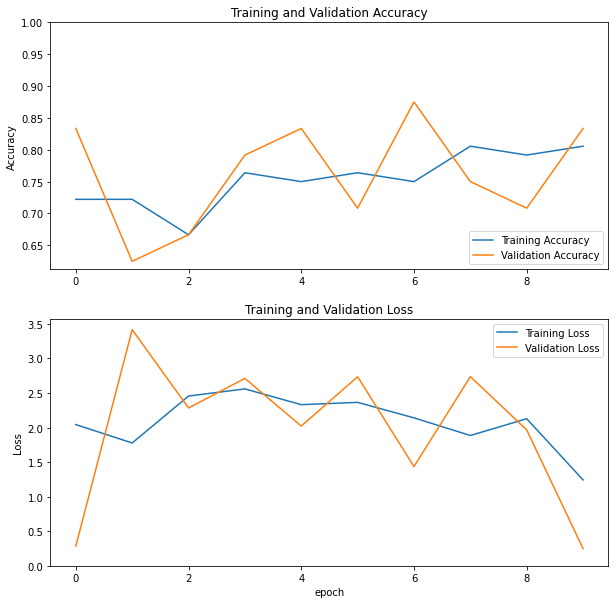

In [39]:
plt.figure(figsize=(10, 10))

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

In [40]:
loss, accuracy = model.evaluate(test_batches)

print(f'Accuracy: {accuracy}')
print(f'Loss: {loss}')

1/1 [==============================] - 0s 292ms/step - loss: 0.5649 - accuracy: 0.6667
Accuracy: 0.6666666865348816
Loss: 0.564914882183075


**Observación**

Finalizamos la experimentación con un *accuracy* próximo al **0.67**.
Un resultado un poco decepcionante al tener en cuenta que con el otro modelo se obtuvieron métricas excelentes.

## **Ejercicio 3.2** (OPCIONAL)

Utilizar *MobileNet V2* como modelo base para extracción de características y reemplace el clasificador construido mediante una **ANN** en el tutorial anterior con un clasificador [SVM](https://scikit-learn.org/stable/modules/svm.html). Verificar la performance del clasificador para el dataset `cats_vs_dogs` y el dataset del ejemplo anterior.

**Cats vs. Dogs**

In [41]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2.
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

base_model.trainable = False

In [42]:
global_average_layer = keras.layers.GlobalAveragePooling2D()

# SVM Classifier.
SVM_layer = keras.layers.Dense(1,
                               activation='linear',
                               kernel_regularizer=keras.regularizers.l2(0.01))

In [43]:
model = keras.Sequential([base_model, global_average_layer, SVM_layer])

model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [44]:
initial_epochs = 10

history = model.fit(Cat_vs_Dog['TRAIN'],
                    epochs=initial_epochs,
                    validation_data=Cat_vs_Dog['VALIDATION'])

Epoch 1/10
582/582 [==============================] - 76s 123ms/step - loss: 1.0190 - accuracy: 0.5147 - val_loss: 0.9827 - val_accuracy: 0.5198
Epoch 2/10
582/582 [==============================] - 71s 118ms/step - loss: 0.9356 - accuracy: 0.5451 - val_loss: 0.9012 - val_accuracy: 0.5426
Epoch 3/10
582/582 [==============================] - 73s 122ms/step - loss: 0.8564 - accuracy: 0.5767 - val_loss: 0.8231 - val_accuracy: 0.5701
Epoch 4/10
582/582 [==============================] - 71s 118ms/step - loss: 0.7814 - accuracy: 0.6079 - val_loss: 0.7493 - val_accuracy: 0.5954
Epoch 5/10
582/582 [==============================] - 71s 119ms/step - loss: 0.7119 - accuracy: 0.6387 - val_loss: 0.6820 - val_accuracy: 0.6307
Epoch 6/10
582/582 [==============================] - 71s 119ms/step - loss: 0.6484 - accuracy: 0.6685 - val_loss: 0.6204 - val_accuracy: 0.6647
Epoch 7/10
582/582 [==============================] - 71s 119ms/step - loss: 0.5910 - accuracy: 0.6963 - val_loss: 0.5650 - val_ac

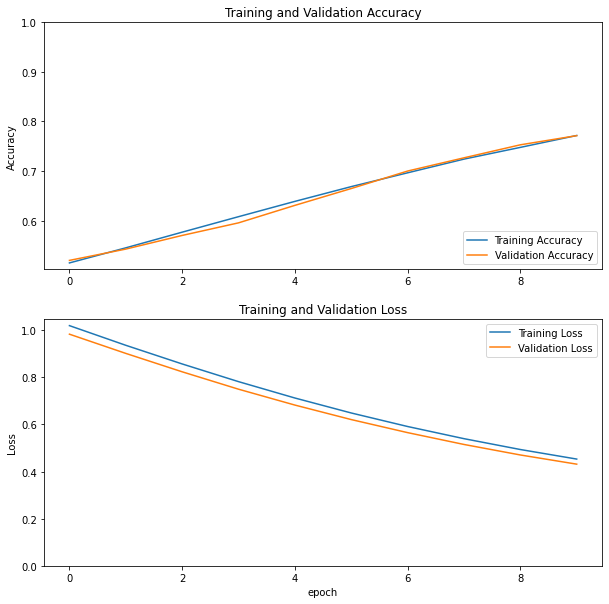

In [45]:
plt.figure(figsize=(10, 10))

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

In [46]:
loss, accuracy = model.evaluate(Cat_vs_Dog['TEST'])

print(f'Accuracy: {accuracy}')
print(f'Loss: {loss}')

73/73 [==============================] - 7s 88ms/step - loss: 0.4296 - accuracy: 0.7833
Accuracy: 0.7833189964294434
Loss: 0.4295503795146942


**Observación**

Finalizamos la experimentación con un *accuracy* próximo al **0.78**.
En comparación al modelo que no utiliza *SVM* el resultado no es tan alentador.
Hay que reconocer que las gráficas de *loss* y *accuracy* son realmente prometedoras, ya que no solo son suaves, sino que también indican que un entrenamiento más prolongado podría haber mejorado los resultados.

**Cameras vs. Sunflowers**

In [47]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2.
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

base_model.trainable = False

In [48]:
global_average_layer = keras.layers.GlobalAveragePooling2D()

# SVM Classifier.
SVM_layer = keras.layers.Dense(1,
                               activation='linear',
                               kernel_regularizer=keras.regularizers.l2(0.01))

In [49]:
model = keras.Sequential([base_model, global_average_layer, SVM_layer])

model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [50]:
initial_epochs = 10

history = model.fit(Camera_vs_Sunflower['TRAIN'],
                    epochs=initial_epochs,
                    validation_data=Camera_vs_Sunflower['VALIDATION'])

Epoch 1/10
3/3 [==============================] - 5s 644ms/step - loss: 1.1027 - accuracy: 0.5556 - val_loss: 0.9362 - val_accuracy: 0.6250
Epoch 2/10
3/3 [==============================] - 1s 166ms/step - loss: 1.0454 - accuracy: 0.5556 - val_loss: 0.9497 - val_accuracy: 0.6250
Epoch 3/10
3/3 [==============================] - 0s 156ms/step - loss: 1.0448 - accuracy: 0.5556 - val_loss: 1.0025 - val_accuracy: 0.5833
Epoch 4/10
3/3 [==============================] - 0s 155ms/step - loss: 1.0569 - accuracy: 0.5417 - val_loss: 0.9608 - val_accuracy: 0.5833
Epoch 5/10
3/3 [==============================] - 0s 162ms/step - loss: 1.0488 - accuracy: 0.5417 - val_loss: 1.0232 - val_accuracy: 0.4167
Epoch 6/10
3/3 [==============================] - 1s 166ms/step - loss: 0.9838 - accuracy: 0.5556 - val_loss: 0.8923 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 0s 161ms/step - loss: 1.0330 - accuracy: 0.5833 - val_loss: 1.1514 - val_accuracy: 0.5833
Epoch 8/10
3/3 [====

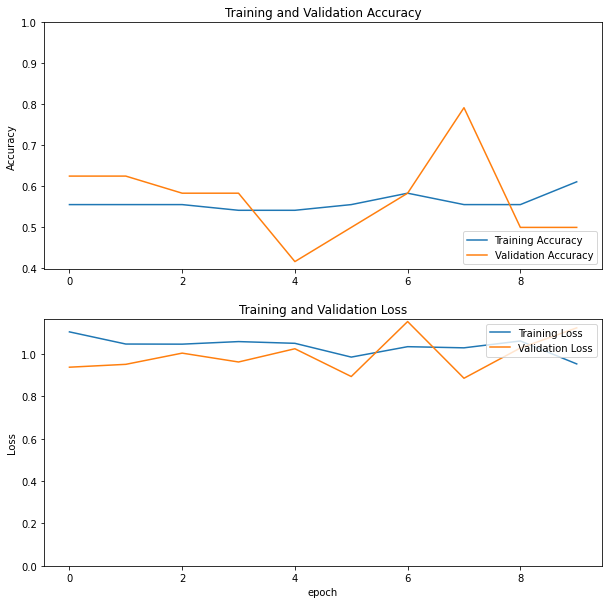

In [51]:
plt.figure(figsize=(10, 10))

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

In [52]:
loss, accuracy = model.evaluate(Camera_vs_Sunflower['TEST'])

print(f'Accuracy: {accuracy}')
print(f'Loss: {loss}')

1/1 [==============================] - 0s 291ms/step - loss: 0.9930 - accuracy: 0.5417
Accuracy: 0.5416666865348816
Loss: 0.9929847121238708


**Observación**

Finalizamos la experimentación con un *accuracy* próximo al **0.54**.
En comparación al modelo que no utiliza *SVM* el resultado es muy malo, obtuvimos el peor desempeño de todo el laboratorio (nuestra red es apenas mejor que el lanzamiento de una moneda).
Quizás el clasificador no sea el correcto para este tipo de problemas, o es posible que debamos replantear el entrenamiento de nuestro modelo.